In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

from utils.db_utils import QUERY
from analysis.monte_carlo import run_monte_carlo_simulation, calculate_monte_carlo_performance_metrics

/Users/louisspencer/Desktop/Trading-Bot/.venv/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
def plot_overall_performance_metrics():
    all_sharpes = all_metrics['backtest_results'].apply(lambda x: json.loads(x)['sharpe_ratio'])
    all_sortinos = all_metrics['backtest_results'].apply(lambda x: json.loads(x)['sortino_ratio'])
    all_calmar_ratios = all_metrics['backtest_results'].apply(lambda x: json.loads(x)['calmar_ratio'])
    n = len(all_sharpes)

    # Probability of Sharpe Ratio >= 1
    p_sharpe = np.sum(all_sharpes >= 1) / n

    # Probability of Sortino Ratio >= 1
    p_sortino = np.sum(all_sortinos >= 1) / n

    # Probability of Calmar Ratio >= 1
    p_calmar = np.sum(all_calmar_ratios >= 1) / n

    # Median Sharpe Ratio
    median_sharpe = np.median(all_sharpes)

    # Median Sortino Ratio
    median_sortino = np.median(all_sortinos)

    # Median Calmar Ratio
    median_calmar = np.median(all_calmar_ratios)

    print(f'Median Sharpe Ratio: {median_sharpe:0.2f}')
    print(f'Median Sortino Ratio: {median_sortino:0.2f}')
    print(f'Median Calmar Ratio: {median_calmar:0.2f}')
    print()
    print(f'Probability of Sharpe Ratio >= 1: {p_sharpe:0.2f}')
    print(f'Probability of Sortino Ratio >= 1: {p_sortino:0.2f}')
    print(f'Probability of Calmar Ratio >= 1: {p_calmar:0.2f}')

    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

    # Histogram of all Sharpe Ratios for a given strategy
    axs[0].set_title(f'Distribution of all Sharpe Ratios for {strat} (n = {n})')
    axs[0].set_xlabel('Sharpe Ratio')
    axs[0].grid()
    sns.histplot(all_sharpes, ax = axs[0], stat = 'probability', color = 'green')

    # Histogram of Sortino Ratios for a given strategy
    axs[1].set_title(f'Distribution of all Sortino Ratios for {strat} (n = {n})')
    axs[1].set_xlabel('Sortino Ratio')
    axs[1].grid()
    sns.histplot(all_sortinos, ax = axs[1], stat = 'probability', color = 'blue');

    # Histogram of all Calmar Ratios for a given strategy
    axs[2].set_title(f'Distribution of all Calmar Ratios for {strat} (n = {n})')
    axs[2].set_xlabel('Calmar Ratio')
    axs[2].grid()
    sns.histplot(all_calmar_ratios, ax = axs[2], stat = 'probability', color = 'red')

    plt.tight_layout();

def plot_in_sample_vs_out_of_sample_sharpe_ratios():
    is_sharpe = all_metrics['backtest_results'].apply(lambda x: json.loads(x)['is_sharpe']).sum()
    oos_sharpe = all_metrics['backtest_results'].apply(lambda x: json.loads(x)['oos_sharpe']).sum()
    df = pd.DataFrame({
        'is_sharpe': is_sharpe,
        'oos_sharpe': oos_sharpe
    })
    # Scatter plot of In-Sample Sharpe Ratios vs. Out-of-Sample Sharpe Ratios
    r = df.corr().iloc[0, 1]
    r_2 = r ** 2

    plt.figure(figsize = (10, 5))
    plt.title(f'In-Sample vs. Out-of-Sample Sharpe Ratios for {strat} (r = {r:.2f}, r^2 = {r_2:.2f})')
    plt.xlabel('In-Sample Sharpe Ratio')
    plt.ylabel('Out-of-Sample Sharpe Ratio')
    plt.grid()

    sns.regplot(x = 'is_sharpe', y = 'oos_sharpe', data = df)

    plt.tight_layout();

def plot_strategy_equity_curve():
    # Calculate buy and hold equity curve
    buy_and_hold_equity_curve = price_data[['close']]
    buy_and_hold_equity_curve['equity'] = 10_000 * (1 + buy_and_hold_equity_curve['close'].pct_change().fillna(0)).cumprod()

    # Plot equity curve for a given strategy
    plt.figure(figsize = (10, 5))
    plt.title(f'Equity Curve for {strat} on {symbol_id}')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.grid()        
    # plt.plot(buy_and_hold_equity_curve.index.values, buy_and_hold_equity_curve['equity'])
    seq = strategy_equity_curve.copy()
    seq = seq.set_index('date')

    for i in range(len(trades_data)):
        entry_date = trades_data.iloc[i]['entry_date']
        exit_date = trades_data.iloc[i]['exit_date']

        try:        
            entry_equity = seq.loc[entry_date, 'equity']
            exit_equity = seq.loc[exit_date, 'equity']
        except:
            continue
        
        plt.scatter(entry_date, entry_equity, color = 'green', marker = '^')
        plt.scatter(exit_date, exit_equity, color = 'red', marker = 'v')
    
    plt.plot(seq.index, seq['equity'])
    
    plt.tight_layout();

def plot_price_data():
    # Plot Price Data
    plt.figure(figsize = (10, 5))
    plt.title(f'Price Data for {symbol_id}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()

    # Scatter plot of trades and price data
    for i in range(len(trades_data)):
        entry_date = trades_data.iloc[i]['entry_date']
        exit_date = trades_data.iloc[i]['exit_date']

        try:        
            entry_price = price_data.loc[entry_date, 'close']
            exit_price = price_data.loc[exit_date, 'close']
        except:
            continue
        
        plt.scatter(entry_date, entry_price, color = 'green', marker = '^')
        plt.scatter(exit_date, exit_price, color = 'red', marker = 'v')

    plt.plot(price_data.index, price_data['close'])

    plt.tight_layout();

def plot_monte_carlo_equity_curves():
    sampled_equity_curves = np.random.choice(monte_carlo_equity_curves.columns, 1000)
    title = 'Monte Carlo Simulations of Equity Curves Over Time'
    monte_carlo_equity_curves[sampled_equity_curves].plot(figsize = (20, 5), legend = False)

    plt.title(title)
    plt.xlabel('Date')
    plt.grid()
    plt.ylabel('Simulated Equity Value (USD)');

def plot_bootstrapped_sharpe_sortino_calmar_ratios():
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

    # Probability of Sharpe Ratio being greater than 1
    sharpe_ratio_prob = (np.array(monte_carlo_risk_metrics['sharpe_ratio']) > 1).mean()
    sortino_ratio_prob = (np.array(monte_carlo_risk_metrics['sortino_ratio']) > 1).mean()
    calmar_ratio_prob = (np.array(monte_carlo_risk_metrics['calmar_ratio']) > 1).mean()

    # Median Sharpe Ratio
    median_sharpe_ratio = np.median(monte_carlo_risk_metrics['sharpe_ratio'])
    median_sortino_ratio = np.median(monte_carlo_risk_metrics['sortino_ratio'])
    median_calmar_ratio = np.median(monte_carlo_risk_metrics['calmar_ratio'])

    # 95% Confidence Interval for Sharpe Ratio
    sharpe_ratio_ci = np.percentile(monte_carlo_risk_metrics['sharpe_ratio'], [2.5, 97.5])
    sortino_ratio_ci = np.percentile(monte_carlo_risk_metrics['sortino_ratio'], [2.5, 97.5])
    calmar_ratio_ci = np.percentile(monte_carlo_risk_metrics['calmar_ratio'], [2.5, 97.5])

    print(f'Probability of Sharpe Ratio > 1: {sharpe_ratio_prob:.2f}')
    print(f'Probability of Sortino Ratio > 1: {sortino_ratio_prob:.2f}')
    print(f'Probability of Calmar Ratio > 1: {calmar_ratio_prob:.2f}')
    print()
    print(f'Median Sharpe Ratio: {median_sharpe_ratio:.2f}')
    print(f'Median Sortino Ratio: {median_sortino_ratio:.2f}')
    print(f'Median Calmar Ratio: {median_calmar_ratio:.2f}')
    print()
    print(f'95% Confidence Interval for Sharpe Ratio: {sharpe_ratio_ci}')
    print(f'95% Confidence Interval for Sortino Ratio: {sortino_ratio_ci}')
    print(f'95% Confidence Interval for Calmar Ratio: {calmar_ratio_ci}')

    # Histogram of Monte Carlo Sharpe Ratios
    axs[0].set_title('Distribution of 2,000 Monte Carlo Sharpe Ratios')
    axs[0].set_xlabel('Sharpe Ratio')
    axs[0].grid()
    sns.histplot(monte_carlo_risk_metrics['sharpe_ratio'], ax = axs[0], stat = 'probability', color = 'green')

    # Histogram of Monte Carlo Sortino Ratios
    axs[1].set_title('Distribution of 2,000 Monte Carlo Sortino Ratios')
    axs[1].set_xlabel('Sortino Ratio')
    axs[1].grid()
    sns.histplot(monte_carlo_risk_metrics['sortino_ratio'], ax = axs[1], stat = 'probability', color = 'blue');

    # Histogram of Monte Carlo Calmar Ratios
    axs[2].set_title('Distribution of 2,000 Monte Carlo Calmar Ratios')
    axs[2].set_xlabel('Calmar Ratio')
    axs[2].grid()
    sns.histplot(monte_carlo_risk_metrics['calmar_ratio'], ax = axs[2], stat = 'probability', color = 'red')

    plt.tight_layout();

def plot_bootstrapped_drawdowns():
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

    # Risk of Ruin
    risk_of_ruin = (np.array(monte_carlo_risk_metrics['max_dd']) >= 0.20).mean()

    # Median Avg. Drawdown and Max Drawdown
    median_avg_dd = np.median(monte_carlo_risk_metrics['avg_dd'])
    median_max_dd = np.median(monte_carlo_risk_metrics['max_dd'])

    # 95% Confidence Interval for Avg. Drawdown and Max Drawdown
    avg_dd_ci = np.percentile(monte_carlo_risk_metrics['avg_dd'], [2.5, 97.5])
    max_dd_ci = np.percentile(monte_carlo_risk_metrics['max_dd'], [2.5, 97.5])

    print(f'Risk of Ruin: {risk_of_ruin:.2f}')
    print()
    print(f'Median Avg. Drawdown: {median_avg_dd:.2f}%')
    print(f'Median Max Drawdown: {median_max_dd:.2f}%')
    print()
    print(f'95% Confidence Interval for Avg. Drawdown: {avg_dd_ci}')
    print(f'95% Confidence Interval for Max Drawdown: {max_dd_ci}')

    plt.subplot(121)
    axs[0].set_title('Distribution of 2,000 Monte Carlo Avg. Drawdowns (%)')
    axs[0].set_xlabel('Avg. Drawdown (%)')
    axs[0].grid()

    # Histogram of Avg. Drawdown Pcts.
    sns.histplot(monte_carlo_risk_metrics['avg_dd'], ax = axs[0], stat = 'probability')
    plt.grid()

    plt.subplot(121)
    axs[1].set_title('Distribution of 2,000 Monte Carlo Max Drawdowns (%)')
    axs[1].set_xlabel('Max Drawdown (%)')
    axs[1].grid()

    # Histogram of Monte Carlo Max Drawdown Pcts.
    sns.histplot(monte_carlo_risk_metrics['max_dd'], ax = axs[1], stat = 'probability')
    plt.grid();


In [3]:
symbol_ids = QUERY(
"""
SELECT DISTINCT symbol_id
FROM backtest.backtest_results
ORDER BY symbol_id
"""
)
symbol_ids

,symbol_id
0,1INCH_USDT_BINANCE
1,AAVE_USDT_BINANCE
2,ACH_USDT_BINANCE
3,ACM_USDT_BINANCE
4,ADA_USDT_BINANCE
...,...
201,UNFI_USDT_BINANCE
202,USDT_DAI_BINANCE
203,WLD_USDT_BINANCE
204,XEC_USDT_BINANCE


In [4]:
strats = QUERY(
"""
SELECT DISTINCT strat
FROM backtest.backtest_results
"""
)
strats

,strat
0,MLStrategy
1,RSIStrategy
2,MACrossOver


In [7]:
symbol_id = 'COTI_USDT_BINANCE'
strat = 'MLStrategy'

In [8]:
all_metrics = QUERY(
    f"""
    SELECT *
    FROM backtest.backtest_results
    WHERE
        strat = '{strat}'
    """
)

strategy_equity_curve = QUERY(
    f"""
    SELECT *
    FROM backtest.backtest_equity_curves
    WHERE
        symbol_id = '{symbol_id}' AND
        strat = '{strat}'
    ORDER BY date
    """
)
price_data = QUERY(
    f"""
    SELECT *
    FROM market_data.ohlcv_1m
    WHERE 
        asset_id_base || '_' || asset_id_quote || '_' || exchange_id = '{symbol_id}'
    """
).set_index('origin_time')[['open', 'high', 'low', 'close', 'volume']]

price_data = price_data.resample('1d', label = 'right', closed = 'left').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
})

trades_data = QUERY(
    f"""
    SELECT *
    FROM backtest.backtest_trades
    WHERE
        symbol_id = '{symbol_id}' AND
        strat = '{strat}'
    """
)

monte_carlo_equity_curves = run_monte_carlo_simulation(strategy_equity_curve[['equity']])
monte_carlo_equity_curves.index = strategy_equity_curve['date']
monte_carlo_risk_metrics = calculate_monte_carlo_performance_metrics(monte_carlo_equity_curves)

/Users/louisspencer/Desktop/Trading-Bot/notebooks/monte_carlo.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equity_curve['returns'] = equity_curve['equity'].pct_change().fillna(0)


 10000 / 10000

Median Sharpe Ratio: nan
Median Sortino Ratio: nan
Median Calmar Ratio: nan

Probability of Sharpe Ratio >= 1: 0.35
Probability of Sortino Ratio >= 1: 0.26
Probability of Calmar Ratio >= 1: 0.40


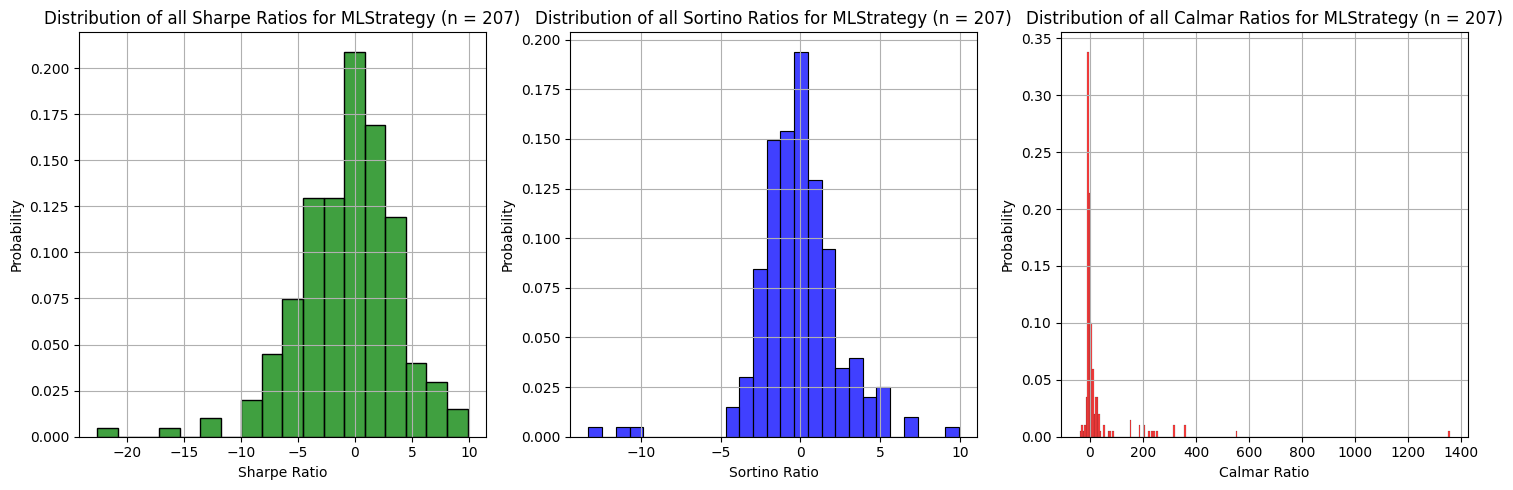

In [9]:
plot_overall_performance_metrics()

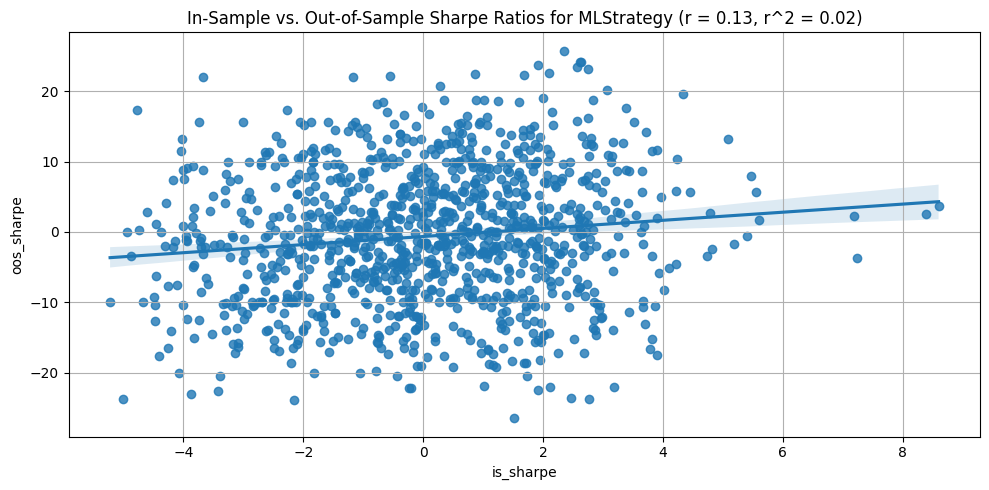

In [10]:
plot_in_sample_vs_out_of_sample_sharpe_ratios()

In [11]:
# Win Rate
win_rate = (trades_data['pnl_pct'] > 0).mean()
print(f'Win Rate: {win_rate:.2f}')

Win Rate: 0.59


In [12]:
# Number of Trades
n_trades = len(trades_data)
print(f'Number of Trades: {n_trades}')

Number of Trades: 22


/var/folders/bn/k4t28qzx3qx1l712qxdnrxcm0000gn/T/ipykernel_42264/3972386412.py:79: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  buy_and_hold_equity_curve['equity'] = 10_000 * (1 + buy_and_hold_equity_curve['close'].pct_change().fillna(0)).cumprod()
/var/folders/bn/k4t28qzx3qx1l712qxdnrxcm0000gn/T/ipykernel_42264/3972386412.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_and_hold_equity_curve['equity'] = 10_000 * (1 + buy_and_hold_equity_curve['close'].pct_change().fillna(0)).cumprod()


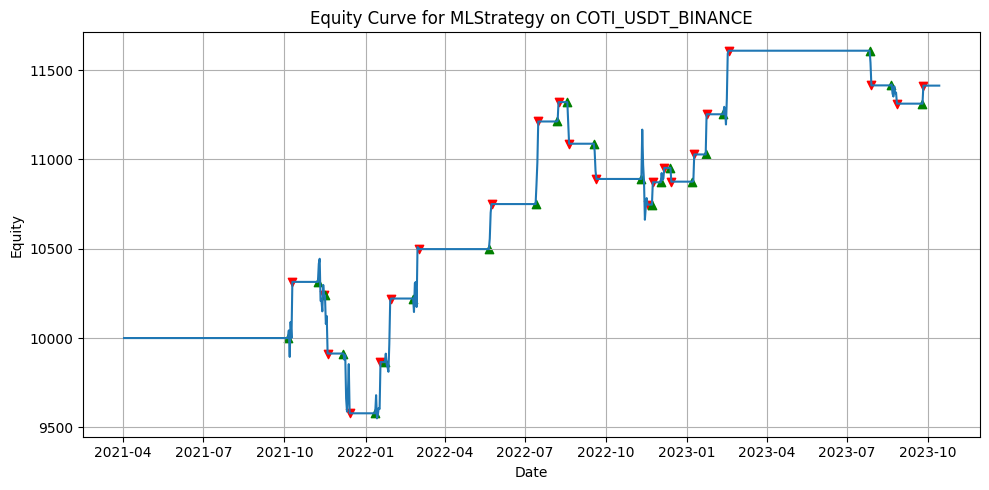

In [13]:
plot_strategy_equity_curve()

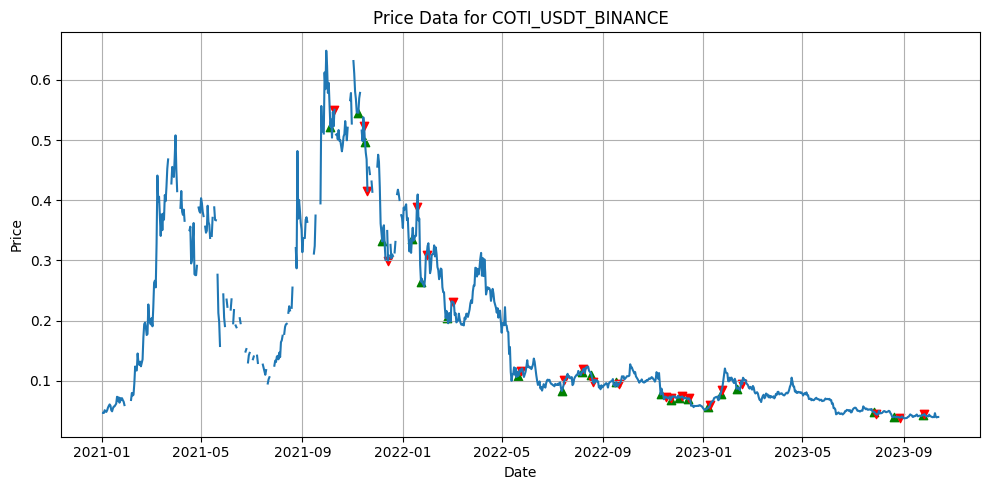

In [14]:
plot_price_data()

In [15]:
trades_data['trade_duration'] = (trades_data['exit_date'] - trades_data['entry_date']).dt.total_seconds() / (60 * 60 * 24)

# Average trade duration in days for profitable trades
print(trades_data[trades_data['pnl_pct'] > 0]['trade_duration'].mean())
# Average trade duration in days for losing trades
print(trades_data[trades_data['pnl_pct'] < 0]['trade_duration'].mean())


3.6923076923076925
4.333333333333333


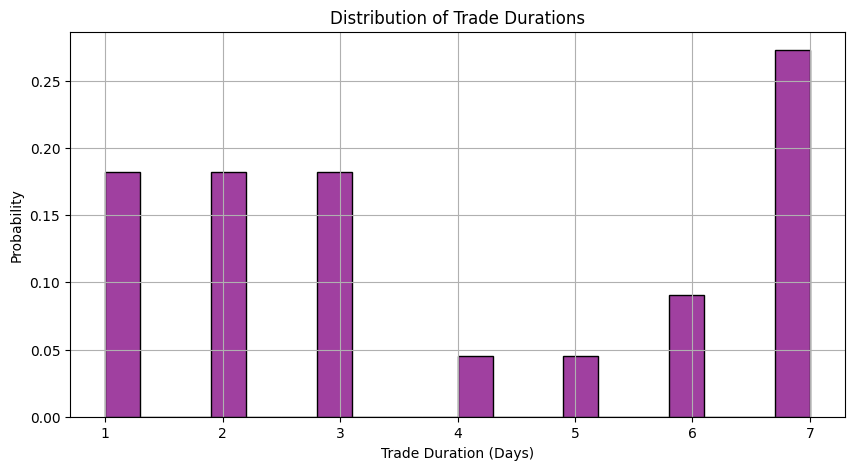

In [16]:
# distribution of trade durations
trade_durations = trades_data['exit_date'] - trades_data['entry_date']
trade_durations = trade_durations.dt.total_seconds() / (60 * 60 * 24)

plt.figure(figsize = (10, 5))
plt.title('Distribution of Trade Durations')
plt.xlabel('Trade Duration (Days)')
plt.grid()
sns.histplot(trade_durations, stat = 'probability', color = 'purple', bins = 20);


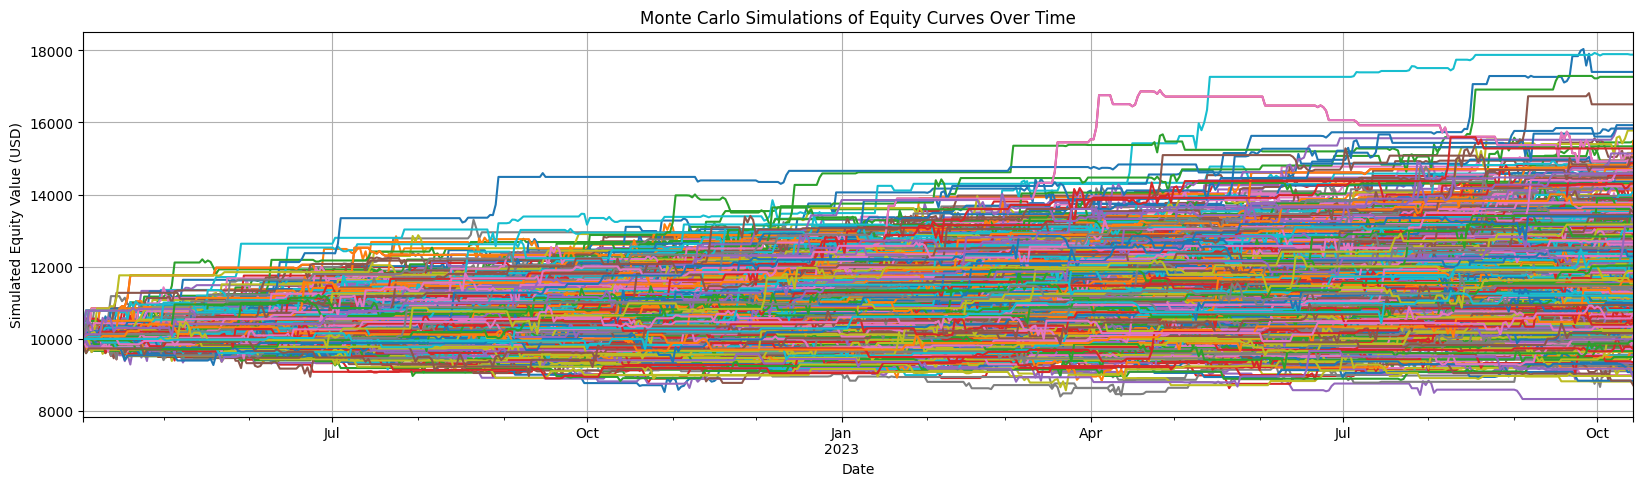

In [21]:
plot_monte_carlo_equity_curves()

Probability of Sharpe Ratio > 1: 0.34
Probability of Sortino Ratio > 1: 0.07
Probability of Calmar Ratio > 1: 0.40

Median Sharpe Ratio: 0.77
Median Sortino Ratio: 0.42
Median Calmar Ratio: 0.77

95% Confidence Interval for Sharpe Ratio: [-0.36657064  1.8516363 ]
95% Confidence Interval for Sortino Ratio: [-0.18269219  1.23982625]
95% Confidence Interval for Calmar Ratio: [-0.21805098  3.48587664]


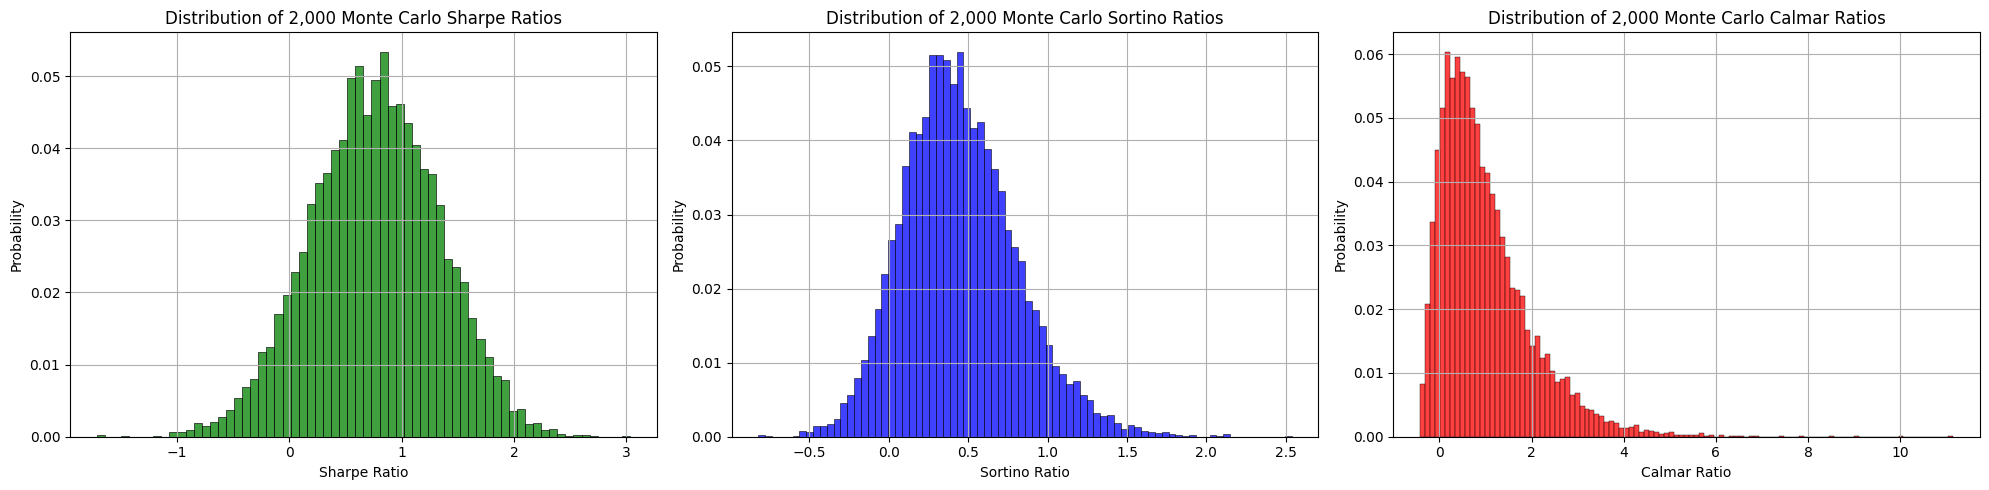

In [17]:
plot_bootstrapped_sharpe_sortino_calmar_ratios()

Risk of Ruin: 0.00

Median Avg. Drawdown: -2.78%
Median Max Drawdown: -6.90%

95% Confidence Interval for Avg. Drawdown: [-8.01495154 -1.14925598]
95% Confidence Interval for Max Drawdown: [-15.02265997  -3.38487765]


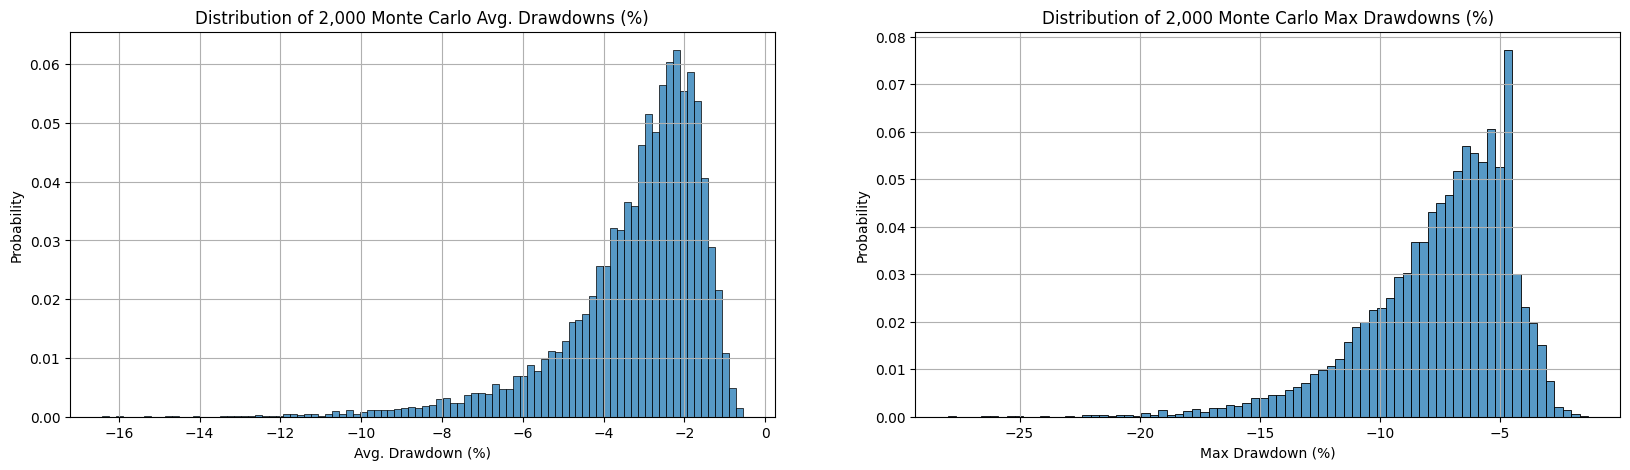

In [18]:
plot_bootstrapped_drawdowns()